<a href="https://colab.research.google.com/github/joony0512/Deep_Learning_Class/blob/main/Part5/P5_Ch06_CH06_08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM seq2seq

## DataLoader 만들기

In [1]:
!pip install portalocker

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
import sys
from datetime import datetime

drive_project_root = '/content/drive/MyDrive/#fastcampus'
sys.path.append(drive_project_root)
!pip install -r '/content/drive/MyDrive/#fastcampus/requirements.txt'

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >=0 :
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell')
else :
    print(gpu_info)

Fri Jul 14 07:40:53 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install omegaconf
!pip install torch_optimizer
!pip install wandb
!pip install efficientnet_pytorch==0.7.1
!pip install hydra-core==1.1
!pip install pytorch-lightning
!pip install --upgrade torchmetrics
!pip install --upgrade pytorch-lightning

In [5]:
# for data loading
from typing import List
from typing import Dict
from typing import Union
from typing import Any
from typing import Optional
from typing import Iterable
from typing import Callable
from abc import abstractmethod
from abc import ABC
from datetime import datetime
from functools import partial
from collections import Counter
from collections import OrderedDict
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
from torch import optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import torch.nn as nn
import pytorch_lightning as pl
from pprint import pprint

from torchtext import data
from torchtext import datasets
from torchtext.datasets import Multi30k
from torchtext.data.utils import get_tokenizer
from torchtext.data.functional import to_map_style_dataset
from torchtext.vocab import Vocab, build_vocab_from_iterator, vocab
import spacy

# for contiguration
from omegaconf import DictConfig
from omegaconf import OmegaConf
import hydra
from hydra.core.config_store import ConfigStore

# for logger
from torch.utils.tensorboard import SummaryWriter
import wandb
os.environ["WANDB_START_METHOD"] ="thread"

In [6]:

%cd /content/drive/MyDrive/#fastcampus
from data_utils import dataset_split
from config_utils import flatten_dict
from config_utils import register_config
from config_utils import configure_optimizers_from_cfg
from config_utils import get_loggers
from config_utils import get_callbacks
%cd /content


/content/drive/MyDrive/#fastcampus
/content


In [ ]:
# download spacy data
!python -m spacy download en
!python -m spacy download en_core_web_sm
!python -m spacy download de
!python -m spacy download de_core_news_sm


In [8]:
data_spacy_de_en_cfg = {
    "name" : "spacy_de_en",
    "data_root" : os.path.join(os.getcwd(), "data"),
    "tokenizer" : "spacy",
    "src_lang" : "de",
    "tgt_lang" : "en",
    "src_index" : 0,
    "tgt_index" : 1,
    "vocab" :{
        "special_symbol2index" :{
            "<unk>" : 0, # 모르는 단어 처리
            "<pad>" : 1, # 길이 다른것 패딩으로 처리
            "<bos>" : 2, # 끝부분 표시
            "<eos>" : 3, # 첫부분 표시
        } ,
        "special_first" : True, # 위의 것들을 맨처음으로 배치
        "min_freq" : 2,
    }
}

data_cfg = OmegaConf.create(data_spacy_de_en_cfg)
print(OmegaConf.to_yaml(data_cfg))

name: spacy_de_en
data_root: /content/data
tokenizer: spacy
src_lang: de
tgt_lang: en
src_index: 0
tgt_index: 1
vocab:
  special_symbol2index:
    <unk>: 0
    <pad>: 1
    <bos>: 2
    <eos>: 3
  special_first: true
  min_freq: 2



In [9]:
train_data, valid_data, test_data = Multi30k(data_cfg.data_root)
test_data = to_map_style_dataset(test_data)

In [10]:
for i in test_data :
    print(i)
    break

('Ein Mann mit einem orangefarbenen Hut, der etwas anstarrt.', 'A man in an orange hat starring at something.')


In [11]:
# 1. token_transform ( token ... )
def get_token_transform(data_cfg : DictConfig) -> dict :
    token_transform : dict ={}
    token_transform[data_cfg.src_lang] = get_tokenizer(
        data_cfg.tokenizer, language = data_cfg.src_lang
        )
    token_transform[data_cfg.tgt_lang] = get_tokenizer(
        data_cfg.tokenizer, language = data_cfg.tgt_lang
        )
    return token_transform

token_transform = get_token_transform(data_cfg)

/usr/local/lib/python3.10/dist-packages/torchtext/data/utils.py:105: UserWarning: Spacy model "de" could not be loaded, trying "de_core_news_sm" instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchtext/data/utils.py:105: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(


In [12]:
# 2. vocab_transform

def yeild_tokens(
    data_iter : Iterable, lang : str, lang2index : Dict[str, int],
) -> List[str] :
    """help function to yeild list of tokens"""
    for data_sample in data_iter:
        yield token_transform[lang](data_sample[lang2index[lang]])

def get_vocab_transform(data_cfg : DictConfig) -> dict :
    vocab_transform : dict = {}
    for ln in [data_cfg.src_lang, data_cfg.tgt_lang]:
        # build from train_data
        train_iter = Multi30k(
            split = 'train', language_pair =(data_cfg.src_lang, data_cfg.tgt_lang)
        )
        # create torchtext's Vocab object
        vocab_transform[ln] =build_vocab_from_iterator(
            yeild_tokens(
                train_iter,
                ln,
                {
                    data_cfg.src_lang : data_cfg.src_index,
                    data_cfg.tgt_lang : data_cfg.tgt_index,
                }
            ),
            min_freq = data_cfg.vocab.min_freq,
            specials = list(data_cfg.vocab.special_symbol2index.keys()),
            special_first = True
        )

    # set UNKNOWM as the default index, --> index가 unknown으로 return : token이 찾아지지 않을 경우
    # 만약 세팅되지 않으면 runtime error가 날 수 있다.
    for ln in [data_cfg.src_lang, data_cfg.tgt_lang]:
        vocab_transform[ln].set_default_index(data_cfg.vocab.special_symbol2index["<unk>"])
    return vocab_transform

vocab_transform = get_vocab_transform(data_cfg)


In [13]:
print(vocab_transform['de']['<bos>'])
print(vocab_transform['en']['<bos>'])
print(vocab_transform['en']['hello'],vocab_transform['en']['world'])

2
2
5465 1870


In [14]:
# 3. integrated transforms
# --> text_transform : [token_transform -> vocab_transform -> torch.tensor transform]

# helper function for collate_fn

def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms :
            txt_input = transform(txt_input)
        return txt_input
    return func

# convert to torch.tensor with bos & eos
def tensor_transform(token_ids : List[int], bos_index : int, eos_index : int ):
    return torch.cat(
        (torch.tensor([bos_index]),torch.tensor(token_ids) ,torch.tensor([eos_index]))
        )

# src & tgt lang language text_transforms to convert raw strings --> tensor indices
def get_text_transform(data_cfg: DictConfig):
    text_transform = {}
    for ln in [data_cfg.src_lang, data_cfg.tgt_lang]:
        text_transform[ln] = sequential_transforms(
            token_transform[ln],
            vocab_transform[ln],
            partial(
                tensor_transform,
                bos_index = data_cfg.vocab.special_symbol2index["<bos>"],
                eos_index = data_cfg.vocab.special_symbol2index["<eos>"],
            )
        )
    return text_transform

text_transform = get_text_transform(data_cfg)

In [15]:
print(text_transform["en"]('hello'))
print(text_transform["en"]('hello,'))
print(text_transform["en"]('hello, how'))
print(text_transform["en"]('hello, how are you ?'))

tensor([   2, 5465,    3])
tensor([   2, 5465,   15,    3])
tensor([   2, 5465,   15,  889,    3])
tensor([   2, 5465,   15,  889,   17, 1328, 2470,    3])


In [16]:
# 4. collate_fn --> batch를 전처리 할까?

def collate_fn(batch, data_cfg: DictConfig):
    src_batch , tgt_batch =[], []

    for src_sample, tgt_sample in batch :
        src_batch.append(text_transform[data_cfg.src_lang](src_sample.rstrip('\n')))
        tgt_batch.append(text_transform[data_cfg.tgt_lang](tgt_sample.rstrip('\n')))

    src_batch = pad_sequence(src_batch, padding_value= data_cfg.vocab.special_symbol2index['<pad>'])
    tgt_batch = pad_sequence(tgt_batch, padding_value= data_cfg.vocab.special_symbol2index['<pad>'])
    return src_batch, tgt_batch

def get_collate_fn(cfg : DictConfig):
    return partial(collate_fn, data_cfg = cfg.data)

# 5. DataLoader

def get_multi30k_dataloader(split_mode : str , language_pair : tuple, batch_size : int, collate_fn: Callable):

    iter = Multi30k(split=split_mode, language_pair =language_pair)
    dataset = to_map_style_dataset(iter)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size =batch_size , collate_fn = collate_fn )
    return dataloader


test_dataloader =get_multi30k_dataloader('test', (data_cfg.src_lang, data_cfg.tgt_lang), 3, collate_fn = partial(collate_fn, data_cfg = data_cfg))

In [17]:
for i in test_dataloader :
    print(i)
    break

(tensor([[   2,    2,    2],
        [   5,    5,    5],
        [  12, 3686,   27],
        [  10, 4015,    7],
        [   6,   86,    6],
        [ 178,   43, 2872],
        [ 108,    0, 3028],
        [   8,  120,   20],
        [  16,   28,  295],
        [  78,    6,   10],
        [   0,   52,    6],
        [   4,  327, 4942],
        [   3,    4,    4],
        [   1,    3,    3]]), tensor([[   2,    2,    2],
        [   6,    6,    6],
        [  12, 3374,   33],
        [   7, 4932,    7],
        [  28,   10,  872],
        [  91,   82,  234],
        [  68,    9, 3453],
        [2670, 2602,    4],
        [  20,   51,  343],
        [ 122,  101,   14],
        [   5,    7,    4],
        [   3,   44,   44],
        [   1,   13,  840],
        [   1,    4,    5],
        [   1,   24,    3],
        [   1,  274,    1],
        [   1,    5,    1],
        [   1,    3,    1]]))


In [18]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True


## pytorch - lighting

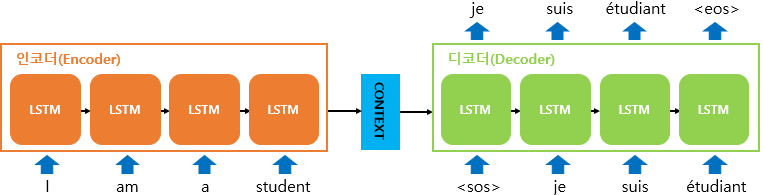


In [96]:
def _test_postprocessing(res : List[str]) -> str :
  if '<eos>' in res :
    res = res[:res.index('<eos>')]
  if '<pad>' in res:
    res = res[:res.index['<pad>']]
  res = " ".join(res).replace("<bos>", "")
  return res


class BaseTranslateLightningModule(pl.LightningModule):
  def __init__(self, cfg : DictConfig):
    super().__init__()
    self.cfg = cfg
    self.loss_function = torch.nn.CrossEntropyLoss(
        ignore_index = cfg.data.vocab.special_symbol2index['<pad>'] # 학습 안하기 위해 지정
    )
  def configure_optimizers(self):
    self._optimizers, self._schedulers = configure_optimizers_from_cfg(
        self.cfg, self
    )
  @abstractmethod # 모델마다 forward가 다르기 때문에 지정. 추상화 메소드
  def forward(self, src, tgt, teacher_forcing_ratio = float):
    raise NotImplementedError()

  def _forward(self, src, tgt, mode : str, teacher_forcing_ratio: float = 0.5):
    # teacher forcing :
    # seq2seq 에서 많이 쓰인다.
    # src -> tgt autoregressive 학습하면, 맨 최초는 학습을 빠르게 한다. 근데 미래부분학습은 ? -> 앞부분 될때까지 기다리기 너무 힘들다
    # 랜덤으로 미래정보도 조금 둬서 뒤에 있는 정보도 학습이 가능하게 하자
    # 0.5 ? --> 0.5확률로 teacher_forcing을 하겠다.

    assert mode in ['train', 'val', 'test']

    # get predictions
    # teacher forcing 용 input -->
    tgt_inputs = tgt[:-1, :] # delete ends for teacher forcing inputs : 맨 뒷부분이 필요하지 않아서 제거한다
    outputs = self(src, tgt_inputs, teacher_forcing_ratio = teacher_forcing_ratio)
    tgt_outputs = tgt[1:, :] # delete start token

    loss = self.loss_function(
        outputs.reshape(-1, outputs.shape[-1]), # [ batch x sequence, other_output_shape]
        tgt_outputs.reshape(-1),
        )
    logs_detail ={
        f"{mode}_src" : src ,
        f"{mode}_tgt" : tgt ,
        f"{mode}_results" : outputs ,

    }

    if mode in ["val", "test"]:
      _, tgt_results = torch.max(outputs, dim = 2)

      src_texts =[]
      tgt_texts =[]
      res_texts =[]

      # convert [L X B X others] --> [B X L X others]
      for src_i in torch.transpose(src, 0, 1).detach().cpu().numpy().tolist(): # no gradient, use cpu, numpy transform, list
        res = vocab_transform[self.cfg.data.src_lang].lookup_tokens(src_i)
        src_texts.append(_test_postprocessing(res))

      for tgt_i in torch.transpose(tgt, 0, 1).detach().cpu().numpy().tolist(): # no gradient, use cpu, numpy transform, list
        res = vocab_transform[self.cfg.data.tgt_lang].lookup_tokens(tgt_i)
        tgt_texts.append(_test_postprocessing(res))

      for tgt_res_i in torch.transpose(tgt_results, 0, 1).detach().cpu().numpy().tolist(): # no gradient, use cpu, numpy transform, list
        res = vocab_transform[self.cfg.data.tgt_lang].lookup_tokens(tgt_res_i)
        res_texts.append(_test_postprocessing(res))

      text_result_summary ={
          f"{mode}_src_text" : src_texts,
          f"{mode}_tgt_text" : tgt_texts,
          f"{mode}_results_text" : res_texts,
      }
      print(f"{self.global_step} step: \n src_text: {src_texts[0]}, \n tgt texts : {tgt_texts[0]}, \n result_text: {res_texts[0]}")
      logs_detail.update(text_result_summary)

    return {f"{mode}_loss":loss}, logs_detail

  def training_step(self, batch, batch_idx):
    src, tgt = batch[0], batch[1]
    logs, _ =  self._forward(src, tgt, "train", self.cfg.model.teacher_forcing_ratio)
    self.log_dict(logs)
    logs['loss'] = logs['train_loss']
    return logs

  def validation_step(self, batch, batch_idx):
    src, tgt = batch[0], batch[1]
    logs, logs_detail =  self._forward(src, tgt, "val", 0.0)
    self.log_dict(logs)
    logs['loss'] = logs['val_loss']
    logs.update(logs_detail)
    return logs

  def test_step(self, batch, batch_idx):
    src, tgt = batch[0], batch[1]
    logs, logs_detail =  self._forward(src, tgt, "test", 0.0)
    self.log_dict(logs)
    logs['loss'] = logs['test_loss']
    logs.update(logs_detail)
    return logs

## model definition


In [97]:
# utils for initialization
def init_weights(model : Union[nn.Module, pl.LightningModule]):
  for name, param in model.named_parameters():
    nn.init.uniform_(param.data, -0.08, 0.08)


In [98]:
# model definition

# 1. encoder (??)
class LSTMEncoder(nn.Module):
  def __init__(
      self,
      input_dim : int,
      embed_dim : int,
      hidden_dim : int,
      n_layers : int,
      dropout : float,
  ):
    super().__init__()
    self.input_dim = input_dim
    self.hidden_dim = hidden_dim
    self.n_layers = n_layers
    self.embedding = nn.Embedding(input_dim, embed_dim)
    self.rnn = nn.LSTM(embed_dim, hidden_dim, n_layers, dropout = dropout)
    self.dropout = nn.Dropout(dropout)

    #initialize weights
    self.apply(init_weights)


  def forward(self, src):
    # src = [seq_len, batch_size]
    embedded = self.dropout(self.embedding(src)) # [seq_len, batch_size, emb_dim]

    outputs , (hidden, cell)=self.rnn(embedded)

    # outputs = [seq_len, batch_size, hidden_dim * n directional]
    # hidden , cell = [n_layers * n_directions , batch_size, hidden_dim ]

    # outputs will be used from top hidden layers
    return hidden, cell

# 2. decoder (??)
class LSTMDecoder(nn.Module):
  def __init__(
      self,
      output_dim : int,
      embed_dim : int,
      hidden_dim : int,
      n_layers : int,
      dropout : float,
  ):
    super().__init__()
    self.hidden_dim = hidden_dim
    self.n_layers = n_layers

    self.output_dim =output_dim
    self.embedding = nn.Embedding(output_dim, embed_dim)
    self.rnn = nn.LSTM(embed_dim, hidden_dim, n_layers, dropout = dropout)
    self.fc_out = nn.Linear(hidden_dim, output_dim)

    self.dropout = nn.Dropout(dropout)

  def forward(self, input, hidden, cell):
    # input : [batch size X ...] <- start_token
    # outputs = [seq_len, batch_size, hidden_dim * n directional]
    # hidden , cell = [n_layers * 1_directions , batch_size, hidden_dim ]

    input = input.unsqueeze(0) # <- [1, batch_size]
    embedded = self.dropout(self.embedding(input))

    #embedding = [1, batch_size, embed_dim]
    output , (hidden, cell) = self.rnn(embedded, (hidden, cell))

    # output = [1, batch_size, hidden_dim]
    # hidden , cell = [n_layers * 1_directions , batch_size, hidden_dim ]

    prediction = self.fc_out(output.squeeze(0)) #[ batch_size, output_dim]

    return prediction, hidden, cell

# 3. Seq2Seq(cfg) <-- encoder + decoder
class LSTMSeq2Seq(BaseTranslateLightningModule):
  def __init__(self, cfg: DictConfig):
    super().__init__(cfg)

    self.encoder = LSTMEncoder(**cfg.model.enc)
    self.decoder = LSTMDecoder(**cfg.model.dec)

    assert self.encoder.hidden_dim == self.decoder.hidden_dim
    assert self.encoder.n_layers == self.decoder.n_layers

    # parameter initializing
    self.apply(init_weights)

  def forward(self, src, tgt, teacher_forcing_ratio : float =0.5):

    # src, tgt = [seq_len (can be diffrent), batch_size]
    # for val, test teacher forcing should be 0.0

    batch_size = tgt.shape[1]
    tgt_len = tgt.shape[0]
    tgt_vocab_size = self.decoder.output_dim

    # tensor to store decoder outputs
    outputs = torch.zeros(tgt_len, batch_size, tgt_vocab_size).to(self.device)

    hidden, cell = self.encoder(src)

    # start_token_input (<sos> tokens)
    input = tgt[0, :]
    for t in range(1, tgt_len):

      # get one cell's output
      output, hidden, cell = self.decoder(input, hidden, cell)

      # set to all outputs results
      outputs[t] = output

      # decide whether going to use teacher forcing or not.
      teacher_force = random.random() < teacher_forcing_ratio

      top1 = output.argmax(1) #logits 에서 가장 확률높은 토큰 뽑기

      input = tgt[t] if teacher_force else top1

    return outputs




# model 실행

In [99]:
data_spacy_de_en_cfg = {
    "name" : "spacy_de_en",
    "data_root" : os.path.join(os.getcwd(), "data"),
    "tokenizer" : "spacy",
    "src_lang" : "de",
    "tgt_lang" : "en",
    "src_index" : 0,
    "tgt_index" : 1,
    "vocab" :{
        "special_symbol2index" :{
            "<unk>" : 0, # 모르는 단어 처리
            "<pad>" : 1, # 길이 다른것 패딩으로 처리
            "<bos>" : 2, # 끝부분 표시
            "<eos>" : 3, # 첫부분 표시
        } ,
        "special_first" : True, # 위의 것들을 맨처음으로 배치
        "min_freq" : 2,
    }
}

data_cfg = OmegaConf.create(data_spacy_de_en_cfg)

# get_dataset
train_data, valid_data, test_data = Multi30k(data_cfg.data_root)

token_transform = get_token_transform(data_cfg)
vocab_transform = get_vocab_transform(data_cfg)

In [100]:
# model configs

model_translate_lstm_seq2seq_cfg = {
    "name" : "LSTMSeq2Seq",
    "enc" : {
        "input_dim" : len(vocab_transform[data_cfg.src_lang]),
        "embed_dim" : 256,
        "hidden_dim" : 256,
        "n_layers" : 2,
        "dropout" : 0.5,
    },
    "dec" : {
        "output_dim" : len(vocab_transform[data_cfg.tgt_lang]),
        "embed_dim" : 256,
        "hidden_dim" : 256,
        "n_layers" : 2,
        "dropout" : 0.5,
    },
    "teacher_forcing_ratio" : 0.5,
}

# opt_cfg
opt_cfg = {
    "optimizers" : [
        {
            "name" : "RAdam",
            "kwargs" :{
                "lr" : 1e-3,
            }
        }
    ],
    "lr_schedulers" :[
        {
        "name" : None,
        "kwargs" :{
            "warmup_end_stages" : 1000
        }
        }
    ]
}

_merged_cfg_presets = {
    "LSTM_seq2seq_de_en_translate" :{
        "opt" : opt_cfg,
        "data" : data_spacy_de_en_cfg,
        "model" : model_translate_lstm_seq2seq_cfg,
    },
}

# clear config hydra instance first
hydra.core.global_hydra.GlobalHydra.instance().clear()

# resister preset configs
register_config(_merged_cfg_presets)

# initialization & compose configs
hydra.initialize(config_path=None)
cfg = hydra.compose('LSTM_seq2seq_de_en_translate')

# override some cfg
run_name = f"{datetime.now().isoformat(timespec = 'seconds')}-{cfg.model.name}-{cfg.data.name}"

project_root_dir = os.path.join(
    drive_project_root, 'runs', "de_en_translate_tutorials"
    )
save_dir = os.path.join(project_root_dir, run_name)
run_root_dir = os.path.join(project_root_dir ,run_name)

# train configs
train_cfg ={
    'train_batch_size' : 128,
    'val_batch_size' : 32,
    'test_batch_size' : 32,
    'train_val_split' : [0.9,0.1],
    'run_root_dir' : run_root_dir,
    'trainer_kwargs' : {
        'accelerator': 'gpu',
        'num_nodes' : 0,
        'max_epochs' :50,
        'val_check_interval': 1.0, #train 1epoch당 val 1회
        'log_every_n_steps' : 100,
        # 'flush_logs_every_n_steps' : 100, #100번 step마다
    }

}
# logger configs
log_cfg = {
    'loggers' : {
        'WandbLogger' : {
            'project' : 'fastcampus_de_en_translate_tutorials',
            'name' : run_name,
            'tags' : ['fastcampus_de_en_translate_tutorials'],
            'save_dir' : run_root_dir,

        },
        'TensorBoardLogger' : {
            'save_dir' : project_root_dir,
            'name' : run_name,
        }
    },
    'callbacks' : {
        'ModelCheckpoint' : {
            'save_top_k' : 3,
            'monitor' : 'val_loss',
            'mode' : 'min',
            'verbose' : True,
            'dirpath' : os.path.join(run_root_dir, 'weights'),
            'filename' : '{epoch}-{val_loss:.3f}',

        },
        'EarlyStopping' : {
            'monitor' : 'val_loss',
            'mode' : 'min',
            'patience' : 3,
            'verbose' : True
        }
    }
}

# unlock config & set train, log config
OmegaConf.set_struct(cfg, False)
cfg.train =train_cfg
cfg.log = log_cfg

# lock config
OmegaConf.set_struct(cfg, True)
print(OmegaConf.to_yaml(cfg))



opt:
  optimizers:
  - name: RAdam
    kwargs:
      lr: 0.001
  lr_schedulers:
  - name: null
    kwargs:
      warmup_end_stages: 1000
data:
  name: spacy_de_en
  data_root: /content/data
  tokenizer: spacy
  src_lang: de
  tgt_lang: en
  src_index: 0
  tgt_index: 1
  vocab:
    special_symbol2index:
      <unk>: 0
      <pad>: 1
      <bos>: 2
      <eos>: 3
    special_first: true
    min_freq: 2
model:
  name: LSTMSeq2Seq
  enc:
    input_dim: 8014
    embed_dim: 256
    hidden_dim: 256
    n_layers: 2
    dropout: 0.5
  dec:
    output_dim: 6191
    embed_dim: 256
    hidden_dim: 256
    n_layers: 2
    dropout: 0.5
  teacher_forcing_ratio: 0.5
train:
  train_batch_size: 128
  val_batch_size: 32
  test_batch_size: 32
  train_val_split:
  - 0.9
  - 0.1
  run_root_dir: /content/drive/MyDrive/#fastcampus/runs/de_en_translate_tutorials/2023-07-14T09:24:53-LSTMSeq2Seq-spacy_de_en
  trainer_kwargs:
    accelerator: gpu
    num_nodes: 0
    max_epochs: 50
    val_check_interval: 1.0
   

In [101]:
# dataloader def

train_dataloader =get_multi30k_dataloader(
    'train',
    (data_cfg.src_lang, data_cfg.tgt_lang),
    cfg.train.train_batch_size,
    collate_fn = get_collate_fn(cfg)
    )

val_dataloader =get_multi30k_dataloader(
    'valid',
    (data_cfg.src_lang, data_cfg.tgt_lang),
    cfg.train.val_batch_size,
    collate_fn = get_collate_fn(cfg)
    )

test_dataloader =get_multi30k_dataloader(
    'test',
    (data_cfg.src_lang, data_cfg.tgt_lang),
    cfg.train.test_batch_size,
    collate_fn = get_collate_fn(cfg)
    )

In [102]:
# pl trainer def & get model

def get_pl_model(cfg : DictConfig , checkpoint_path : Optional[str] =None):

  if cfg.model.name == "LSTMSeq2Seq":
    model = LSTMSeq2Seq(cfg)
  else :
    raise NotImplementedError("Not Inplemented model")

  if checkpoint_path is not None :
    model = model.load_from_checkpoint(cfg, checkpoint_path = checkpoint_path)
  return model

model = None
model = get_pl_model(cfg)
print(model)

LSTMSeq2Seq(
  (loss_function): CrossEntropyLoss()
  (encoder): LSTMEncoder(
    (embedding): Embedding(8014, 256)
    (rnn): LSTM(256, 256, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): LSTMDecoder(
    (embedding): Embedding(6191, 256)
    (rnn): LSTM(256, 256, num_layers=2, dropout=0.5)
    (fc_out): Linear(in_features=256, out_features=6191, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)


In [103]:
# pytorch lightining trainer def

logger = get_loggers(cfg)
callbacks = get_callbacks(cfg)

trainer =pl.Trainer(
    callbacks = callbacks,
    logger = logger,
    default_root_dir= cfg.train.run_root_dir,
    num_sanity_val_steps=2,
    **cfg.train.trainer_kwargs
)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..


In [104]:
trainer.fit(model, train_dataloader, val_dataloader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | loss_function | CrossEntropyLoss | 0     
1 | encoder       | LSTMEncoder      | 3.1 M 
2 | decoder       | LSTMDecoder      | 4.2 M 
---------------------------------------------------
7.3 M     Trainable params
0         Non-trainable params
7.3 M     Total params
29.332    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

0 step: 
 src_text:  Eine Gruppe von Männern lädt <unk> auf einen Lastwagen, 
 tgt texts :  A group of men are loading cotton onto a truck, 
 result_text: <unk> upward Tye moped moped readying readying readying readying readying readying readying readying readying similar readying readying readying readying readying readying readying similar readying readying readying
0 step: 
 src_text:  Kind spielt auf einem Spielplatz und hängt dabei an Stangen ., 
 tgt texts :  Child playing on a playground , hanging from bars ., 
 result_text: <unk> upward Tye moped moped readying readying readying readying readying readying readying readying readying similar readying readying readying readying readying readying readying similar readying readying readying readying readying


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

227 step: 
 src_text:  Eine Gruppe von Männern lädt <unk> auf einen Lastwagen, 
 tgt texts :  A group of men are loading cotton onto a truck, 
 result_text: <unk> upward Tye moped moped readying readying readying readying readying readying readying readying readying similar readying readying readying readying readying readying readying similar readying readying readying
227 step: 
 src_text:  Kind spielt auf einem Spielplatz und hängt dabei an Stangen ., 
 tgt texts :  Child playing on a playground , hanging from bars ., 
 result_text: <unk> upward Tye moped moped readying readying readying readying readying readying readying readying readying similar readying readying readying readying readying readying readying similar readying readying readying readying readying
227 step: 
 src_text:  Eine bunt gekleidete Frau geht an einem weißen Lastwagen vorbei , der mit Flaschen gefüllt ist ., 
 tgt texts :  A woman in a colorful outfit is walking by a white truck filled with bottles ., 
 result

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 34. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 23. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 22. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collect

227 step: 
 src_text:  Mann in einem kleinen weißen Boot auf einem See ., 
 tgt texts :  Man in a small white boat on a lake ., 
 result_text: <unk> upward Tye moped moped readying readying readying readying readying readying readying readying readying similar readying readying readying readying readying readying readying similar readying readying readying readying readying readying readying
227 step: 
 src_text:  Ein junger Mann mit blondem Haar spricht in ein Mikrofon ., 
 tgt texts :  A young blond - haired man speaks into a microphone ., 
 result_text: <unk> upward Tye moped moped readying readying readying readying readying readying readying readying readying similar readying readying readying readying readying readying readying similar readying
227 step: 
 src_text:  Ein Hund rennt durch das Gras auf die Kamera zu ., 
 tgt texts :  A dog runs through the grass towards the camera ., 
 result_text: <unk> upward Tye moped moped readying readying readying readying readying readying r

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 24. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 25. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


227 step: 
 src_text:  Eine junge Frau spielt ein Saiteninstrument im Haus ., 
 tgt texts :  A young woman practices a string instrument indoors ., 
 result_text: <unk> upward Tye moped moped readying readying readying readying readying readying readying readying readying similar readying readying readying readying readying readying readying similar readying readying readying
227 step: 
 src_text:  Ein Typ rennt vor einem schwarzen Bullen davon ., 
 tgt texts :  A guy is running away from a black bull ., 
 result_text: <unk> upward Tye moped moped readying readying readying readying readying readying readying readying readying similar readying readying readying readying
227 step: 
 src_text:  Ein kleines Mädchen lächelt und streckt ihren Daumen nach oben , während sie vor einer Schildkröte posiert ., 
 tgt texts :  A young girl smiles and sticks her thumb up while posing in front of a turtle ., 
 result_text: <unk> upward Tye moped moped readying readying readying readying readying rea

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 26. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


227 step: 
 src_text:  Ein <unk> Auto , das von vielen <unk> <unk> wird ., 
 tgt texts :  A <unk> car with many firefighters cutting into the car ., 
 result_text: <unk> upward Tye moped moped readying readying readying readying readying readying readying readying readying similar readying readying readying readying readying readying readying similar
227 step: 
 src_text:  Drei Mädchen reiten auf Pferden , wobei sich das <unk> Mädchen im <unk> befindet ., 
 tgt texts :  Three girls are horseback riding with the focus on the <unk> girl ., 
 result_text: <unk> upward Tye moped moped readying readying readying readying readying readying readying readying readying similar readying readying readying readying readying readying readying similar readying readying readying readying
227 step: 
 src_text:  Ein kleiner Junge zeigt seine <unk> <unk> ., 
 tgt texts :  A young boy shows his brown and green bead necklace ., 
 result_text: <unk> upward Tye moped moped readying readying readying readyin

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 28. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 8.735
INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 227: 'val_loss' reached 8.73490 (best 8.73490), saving model to '/content/drive/MyDrive/#fastcampus/runs/de_en_translate_tutorials/2023-07-14T09:24:53-LSTMSeq2Seq-spacy_de_en/weights/epoch=0-val_loss=8.735.ckpt' as top 3


227 step: 
 src_text:  Zwei Männer aus gegnerischen Teams rennen in Richtung eines Fußballs ., 
 tgt texts :  Two men on opposing teams race toward a soccer ball ., 
 result_text: <unk> upward Tye moped moped readying readying readying readying readying readying readying readying readying similar readying readying readying readying readying readying readying similar
227 step: 
 src_text:  Zwei schwarz gekleidete Männer mit einer grünen und einer roten Fliege treten vor einer Menschenmenge auf ., 
 tgt texts :  Two men in black clothes with blue and red bowties are performing in front of a crowd ., 
 result_text: <unk> upward Tye moped moped readying readying readying readying readying readying readying readying readying similar readying readying readying readying readying readying readying


Validation: 0it [00:00, ?it/s]

454 step: 
 src_text:  Eine Gruppe von Männern lädt <unk> auf einen Lastwagen, 
 tgt texts :  A group of men are loading cotton onto a truck, 
 result_text: <unk> upward Tye moped moped readying readying readying readying readying readying readying readying readying similar readying readying readying readying readying readying readying similar readying readying readying
454 step: 
 src_text:  Kind spielt auf einem Spielplatz und hängt dabei an Stangen ., 
 tgt texts :  Child playing on a playground , hanging from bars ., 
 result_text: <unk> upward Tye moped moped readying readying readying readying readying readying readying readying readying similar readying readying readying readying readying readying readying similar readying readying readying readying readying
454 step: 
 src_text:  Eine bunt gekleidete Frau geht an einem weißen Lastwagen vorbei , der mit Flaschen gefüllt ist ., 
 tgt texts :  A woman in a colorful outfit is walking by a white truck filled with bottles ., 
 result

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 454: 'val_loss' reached 8.73490 (best 8.73490), saving model to '/content/drive/MyDrive/#fastcampus/runs/de_en_translate_tutorials/2023-07-14T09:24:53-LSTMSeq2Seq-spacy_de_en/weights/epoch=1-val_loss=8.735.ckpt' as top 3


454 step: 
 src_text:  Drei Mädchen reiten auf Pferden , wobei sich das <unk> Mädchen im <unk> befindet ., 
 tgt texts :  Three girls are horseback riding with the focus on the <unk> girl ., 
 result_text: <unk> upward Tye moped moped readying readying readying readying readying readying readying readying readying similar readying readying readying readying readying readying readying similar readying readying readying readying
454 step: 
 src_text:  Ein kleiner Junge zeigt seine <unk> <unk> ., 
 tgt texts :  A young boy shows his brown and green bead necklace ., 
 result_text: <unk> upward Tye moped moped readying readying readying readying readying readying readying readying readying similar readying readying readying readying readying readying readying similar readying readying readying readying readying readying readying similar readying
454 step: 
 src_text:  Der Junge springt mit einem <unk> aus dem Bett ., 
 tgt texts :  The boy leaps of his bed with a karate kick ., 
 result_tex

Validation: 0it [00:00, ?it/s]

681 step: 
 src_text:  Eine Gruppe von Männern lädt <unk> auf einen Lastwagen, 
 tgt texts :  A group of men are loading cotton onto a truck, 
 result_text: <unk> upward Tye moped moped readying readying readying readying readying readying readying readying readying similar readying readying readying readying readying readying readying similar readying readying readying
681 step: 
 src_text:  Kind spielt auf einem Spielplatz und hängt dabei an Stangen ., 
 tgt texts :  Child playing on a playground , hanging from bars ., 
 result_text: <unk> upward Tye moped moped readying readying readying readying readying readying readying readying readying similar readying readying readying readying readying readying readying similar readying readying readying readying readying
681 step: 
 src_text:  Eine bunt gekleidete Frau geht an einem weißen Lastwagen vorbei , der mit Flaschen gefüllt ist ., 
 tgt texts :  A woman in a colorful outfit is walking by a white truck filled with bottles ., 
 result

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 681: 'val_loss' reached 8.73490 (best 8.73490), saving model to '/content/drive/MyDrive/#fastcampus/runs/de_en_translate_tutorials/2023-07-14T09:24:53-LSTMSeq2Seq-spacy_de_en/weights/epoch=2-val_loss=8.735.ckpt' as top 3


681 step: 
 src_text:  Ein <unk> Auto , das von vielen <unk> <unk> wird ., 
 tgt texts :  A <unk> car with many firefighters cutting into the car ., 
 result_text: <unk> upward Tye moped moped readying readying readying readying readying readying readying readying readying similar readying readying readying readying readying readying readying similar
681 step: 
 src_text:  Drei Mädchen reiten auf Pferden , wobei sich das <unk> Mädchen im <unk> befindet ., 
 tgt texts :  Three girls are horseback riding with the focus on the <unk> girl ., 
 result_text: <unk> upward Tye moped moped readying readying readying readying readying readying readying readying readying similar readying readying readying readying readying readying readying similar readying readying readying readying
681 step: 
 src_text:  Ein kleiner Junge zeigt seine <unk> <unk> ., 
 tgt texts :  A young boy shows his brown and green bead necklace ., 
 result_text: <unk> upward Tye moped moped readying readying readying readyin

Validation: 0it [00:00, ?it/s]

908 step: 
 src_text:  Eine Gruppe von Männern lädt <unk> auf einen Lastwagen, 
 tgt texts :  A group of men are loading cotton onto a truck, 
 result_text: <unk> upward Tye moped moped readying readying readying readying readying readying readying readying readying similar readying readying readying readying readying readying readying similar readying readying readying
908 step: 
 src_text:  Kind spielt auf einem Spielplatz und hängt dabei an Stangen ., 
 tgt texts :  Child playing on a playground , hanging from bars ., 
 result_text: <unk> upward Tye moped moped readying readying readying readying readying readying readying readying readying similar readying readying readying readying readying readying readying similar readying readying readying readying readying
908 step: 
 src_text:  Eine bunt gekleidete Frau geht an einem weißen Lastwagen vorbei , der mit Flaschen gefüllt ist ., 
 tgt texts :  A woman in a colorful outfit is walking by a white truck filled with bottles ., 
 result

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 3 records. Best score: 8.735. Signaling Trainer to stop.
INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 908: 'val_loss' was not in top 3


908 step: 
 src_text:  Drei Mädchen reiten auf Pferden , wobei sich das <unk> Mädchen im <unk> befindet ., 
 tgt texts :  Three girls are horseback riding with the focus on the <unk> girl ., 
 result_text: <unk> upward Tye moped moped readying readying readying readying readying readying readying readying readying similar readying readying readying readying readying readying readying similar readying readying readying readying
908 step: 
 src_text:  Ein kleiner Junge zeigt seine <unk> <unk> ., 
 tgt texts :  A young boy shows his brown and green bead necklace ., 
 result_text: <unk> upward Tye moped moped readying readying readying readying readying readying readying readying readying similar readying readying readying readying readying readying readying similar readying readying readying readying readying readying readying similar readying
908 step: 
 src_text:  Der Junge springt mit einem <unk> aus dem Bett ., 
 tgt texts :  The boy leaps of his bed with a karate kick ., 
 result_tex